# Initialization

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

/home1/05823/tg851228/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [3]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Libraries

In [4]:
def dP(PS):    
    S = PS.shape
    P = 1e5 * np.moveaxis(np.tile(hyai,(S[0],S[1],S[2],1)),3,1) + \
    np.moveaxis(np.tile(PS.values,(31,1,1,1)),0,1) * np.moveaxis(np.tile(hybi,(S[0],S[1],S[2],1)),3,1)
    return P[:, 1:]-P[:, :-1]

In [5]:
# Moist thermo library in numpy
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)

    return Rv*p*qv/(R*esat(T))

def RHsurf(T,qv,P0,PS):
    R = 287
    Rv = 461
    
    return Rv*PS*qv/(R*esat(T))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)
    
    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

In [6]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

In [7]:
def CRH(inp,input_sub,input_div):

    qv0 = inp[:,:30]*input_div[:30]+input_sub[:30]
    T = inp[:,30:60]*input_div[30:60]+input_sub[30:60]
    ps = inp[:,60]*input_div[60]+input_sub[60]

    dP0 = dP(ps)
    qsat0 = qsat(T,P0,ps,hyam,hybm)

    return np.sum(qv0*dP0,axis=1)/np.sum(qsat0*dP0,axis=1)

In [8]:
def qsatsurf(TS,P0,PS):
    R = 287
    Rv = 461
    return R*esat(TS)/(Rv*PS)

In [9]:
# From https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- np ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            if np.sum(w)>0: Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)
            else: Ym[ibin-1] = np.nan; Ystd[ibin-1] = np.nan;

        edge_left = edge
    
    return Ym,Ystd

# Load data

In [10]:
pathref = '/scratch/07088/tg863871/archive/SST_0001Kp_Neuralnet_SPCAM_all_216/atm/hist/SST_0001Kp_Neuralnet_SPCAM_all_216.cam.h1.20'
pathp4K = '/scratch/07088/tg863871/archive/SST_4Kp_Neuralnet_SPCAM_all_v2_216/atm/hist/SST_4Kp_Neuralnet_SPCAM_all_v2_216.cam.h1.20'
pathm4K = '/scratch/07088/tg863871/archive/SST_4Km_Neuralnet_SPCAM_all_small_216/atm/hist/SST_4Km_Neuralnet_SPCAM_all_small_216.cam.h1.20'

In [11]:
datam4K = xr.open_mfdataset(pathm4K+'09-0*-23-00000.nc',decode_times=False)
dataref = xr.open_mfdataset(pathref+'09-0*-23-00000.nc',decode_times=False)
datap4K = xr.open_mfdataset(pathp4K+'09-0*-23-00000.nc',decode_times=False)

/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/wor

# Global statistics

In [21]:
dataref.NN2L_TBOT

<xarray.DataArray 'NN2L_TBOT' (time: 144, lat: 96, lon: 144)>
dask.array<concatenate, shape=(144, 96, 144), dtype=float32, chunksize=(16, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * time     (time) float64 105.0 105.0 105.0 105.0 ... 348.1 348.1 348.1 348.2
Attributes:
    units:      K
    long_name:  Lowest model level temperature

## Inputs

In [23]:
RH0 = {}
TTNS = {}
LHFscaledNS = {}
LHFscaledS = {}
PW = {}
CRH = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
    
    print('RH and T-TNS')
    RH0[data] = RH(d.TBP,d.QBP,1e5,d.PS,d.hyam,d.hybm)
    TTNS[data] = d.TBP-d.TBP[:,-1,:,:]
    print('qsat, PW, CRH')
    PW[data] = sin.trapz(d.QBP*dP(d.PS)/G,axis=1)
    qsat0 = qsat(d.TBP,1e5,d.PS,d.hyam,d.hybm)
    PWsat = sin.trapz(qsat0*dP(d.PS)/G,axis=1)
    CRH[data] = PW[data]/PWsat
    print('LHF')
    qsatS = qsatsurf(d.NN2L_TBOT,d.P0,d.PS)
    LHFscaledNS[data] = d.LHFLX/(L_V*qsat0[:,-1,:,:])
    LHFscaledS[data] = d.LHFLX/(L_V*qsatS)
    print('\n')

data= m4K
RH and T-TNS
qsat, PW, CRH
LHF


data= ref
RH and T-TNS
qsat, PW, CRH
LHF


data= p4K
RH and T-TNS
qsat, PW, CRH
LHF




## Outputs

In [24]:
cpair = 1.00464e3
latvap = 2.501e6
g = 9.8
eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
R_D = 287 # Specific gas constant of dry air in J/K/kg

In [25]:
HEAT = {}
MOIST = {}
ABSHEAT = {}
ABSMOIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K

    HEAT[data] = np.sum(cpair*d.PTTEND*dP(d.PS)/g,axis=1).values
    MOIST[data] = np.sum(latvap*d.PTEQ*dP(d.PS)/g,axis=1).values
    ABSHEAT[data] = np.sum(np.abs(cpair*d.PTTEND*dP(d.PS)/g),axis=1).values
    ABSMOIST[data] = np.sum(np.abs(latvap*d.PTEQ*dP(d.PS)/g),axis=1).values

data= m4K
data= ref
data= p4K


In [26]:
LW = {}
SW = {}
CON = {}
ABSLW = {}
ABSSW = {}
ABSCON = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K

    LW[data] = np.sum(cpair*d.QRL*dP(d.PS)/g,axis=1).values
    SW[data] = np.sum(cpair*d.QRS*dP(d.PS)/g,axis=1).values
    CON[data] = np.sum(cpair*(d.PTTEND-d.QRL-d.QRS)*dP(d.PS)/g,axis=1).values
    
    ABSLW[data] = np.sum(np.abs(cpair*d.QRL*dP(d.PS)/g),axis=1).values
    ABSSW[data] = np.sum(np.abs(cpair*d.QRS*dP(d.PS)/g),axis=1).values
    ABSCON[data] = np.sum(np.abs(cpair*(d.PTTEND-d.QRL-d.QRS)*dP(d.PS)/g),axis=1).values

data= m4K
data= ref
data= p4K


## Histograms

In [35]:
COLOR = ['b','gray','red']

In [37]:
QHIST = {}
RHHIST = {}
THIST = {}
TTNSHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    QHIST[data] = np.histogram(d.QBP.values.flatten(),bins=100)
    RHHIST[data] = np.histogram(RH0[data].values.flatten(),bins=100)
    THIST[data] = np.histogram(d.TBP.values.flatten(),bins=100)
    TTNSHIST[data] = np.histogram(TTNS[data].values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


Text(0.5, 0, 'Temp. - NS temp. [K]')

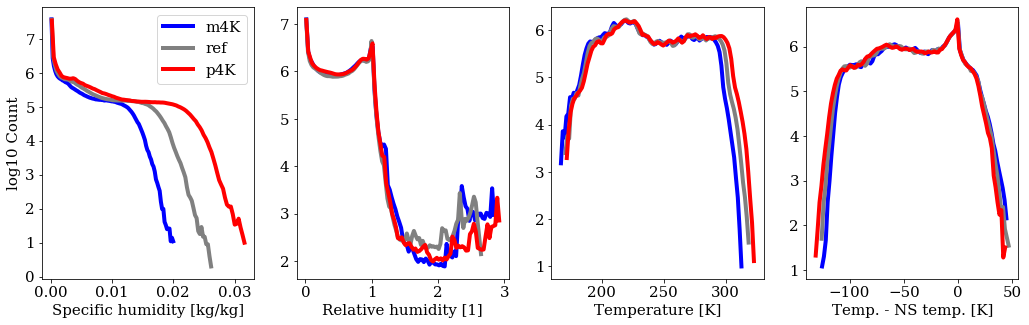

In [38]:
fig,ax = plt.subplots(1,4,figsize=(17.5,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    ax[0].plot(edg2bin(QHIST[data][1]),np.log10(QHIST[data][0]),color=COLOR[idata],label=data)
ax[0].legend()
ax[0].set_ylabel('log10 Count')
ax[0].set_xlabel('Specific humidity [kg/kg]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[1].plot(edg2bin(RHHIST[data][1]),np.log10(RHHIST[data][0]),color=COLOR[idata])
ax[1].set_xlabel('Relative humidity [1]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[2].plot(edg2bin(THIST[data][1]),np.log10(THIST[data][0]),color=COLOR[idata])
ax[2].set_xlabel('Temperature [K]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[3].plot(edg2bin(TTNSHIST[data][1]),np.log10(TTNSHIST[data][0]),color=COLOR[idata])
ax[3].set_xlabel('Temp. - NS temp. [K]')

In [39]:
LHFHIST = {}
SHFHIST = {}
LHFscaledSHIST = {}
LHFscaledNSHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    LHFHIST[data] = np.histogram(d.LHFLX.values.flatten(),bins=100)
    SHFHIST[data] = np.histogram(d.SHFLX.values.flatten(),bins=100)
    LHFscaledSHIST[data] = np.histogram(LHFscaledS[data].values.flatten(),bins=100)
    LHFscaledNSHIST[data] = np.histogram(LHFscaledNS[data].values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ip

(-0.05, 0.3775200866838829)

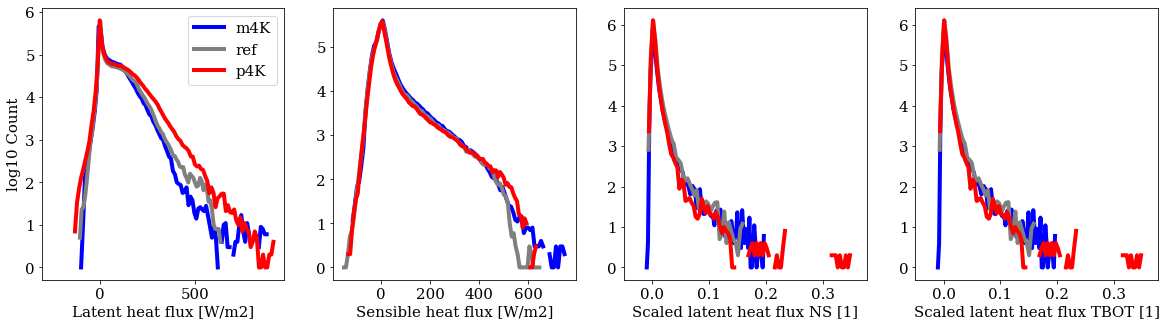

In [40]:
fig,ax = plt.subplots(1,4,figsize=(20,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    ax[0].plot(edg2bin(LHFHIST[data][1]),np.log10(LHFHIST[data][0]),color=COLOR[idata],label=data)
ax[0].legend()
ax[0].set_ylabel('log10 Count')
ax[0].set_xlabel('Latent heat flux [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[1].plot(edg2bin(SHFHIST[data][1]),np.log10(SHFHIST[data][0]),color=COLOR[idata])
ax[1].set_xlabel('Sensible heat flux [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[2].plot(edg2bin(LHFscaledNSHIST[data][1]),np.log10(LHFscaledNSHIST[data][0]),color=COLOR[idata])
ax[2].set_xlabel('Scaled latent heat flux NS [1]')
plt.draw()
ax[2].set_xlim((-0.05,ax[2].get_xlim()[1]))

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[3].plot(edg2bin(LHFscaledNSHIST[data][1]),np.log10(LHFscaledNSHIST[data][0]),color=COLOR[idata])
ax[3].set_xlabel('Scaled latent heat flux TBOT [1]')
plt.draw()
ax[3].set_xlim((-0.05,ax[3].get_xlim()[1]))

In [41]:
HEATHIST = {}
ABSHEATHIST = {}
MOISTHIST = {}
ABSMOISTHIST = {}
CRHHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    HEATHIST[data] = np.histogram(HEAT[data].flatten(),bins=100)
    ABSHEATHIST[data] = np.histogram(ABSHEAT[data].flatten(),bins=100)
    MOISTHIST[data] = np.histogram(MOIST[data].flatten(),bins=100)
    ABSMOISTHIST[data] = np.histogram(ABSMOIST[data].flatten(),bins=100)
    CRHHIST[data] = np.histogram(CRH[data].flatten(),bins=100)

data= m4K
data= ref
data= p4K


/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ip

Text(0.5, 0, 'Absolute moistening [W/m2]')

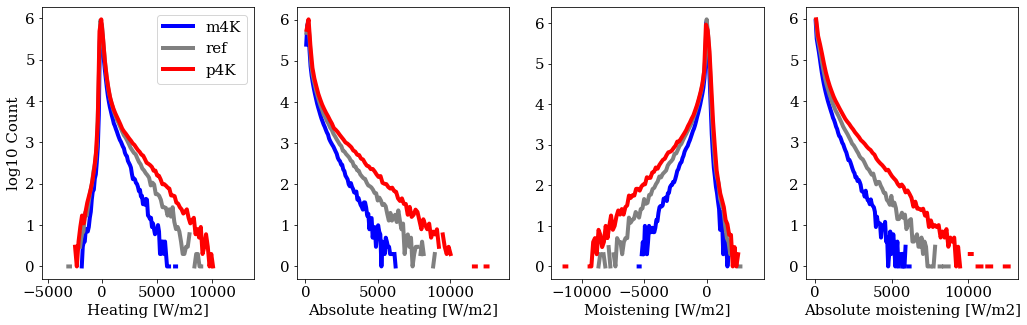

In [42]:
fig,ax = plt.subplots(1,4,figsize=(17.5,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    ax[0].plot(edg2bin(HEATHIST[data][1]),np.log10(HEATHIST[data][0]),color=COLOR[idata],label=data)
ax[0].legend()
ax[0].set_ylabel('log10 Count')
ax[0].set_xlabel('Heating [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[1].plot(edg2bin(ABSHEATHIST[data][1]),np.log10(ABSHEATHIST[data][0]),color=COLOR[idata])
ax[1].set_xlabel('Absolute heating [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[2].plot(edg2bin(MOISTHIST[data][1]),np.log10(MOISTHIST[data][0]),color=COLOR[idata])
ax[2].set_xlabel('Moistening [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[3].plot(edg2bin(ABSMOISTHIST[data][1]),np.log10(ABSMOISTHIST[data][0]),color=COLOR[idata])
ax[3].set_xlabel('Absolute moistening [W/m2]')

In [43]:
LWHIST = {}
SWHIST = {}
CONHIST = {}
ABSLWHIST = {}
ABSSWHIST = {}
ABSCONHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    LWHIST[data] = np.histogram(LW[data].flatten(),bins=100)
    SWHIST[data] = np.histogram(SW[data].flatten(),bins=100)
    CONHIST[data] = np.histogram(CON[data].flatten(),bins=100)
    ABSLWHIST[data] = np.histogram(ABSLW[data].flatten(),bins=100)
    ABSSWHIST[data] = np.histogram(ABSSW[data].flatten(),bins=100)
    ABSCONHIST[data] = np.histogram(ABSCON[data].flatten(),bins=100)

data= m4K
data= ref
data= p4K


/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/work/05823/tg851228/stampede2/M

Text(0.5, 0, 'Absolute Convective Heating [W/m2]')

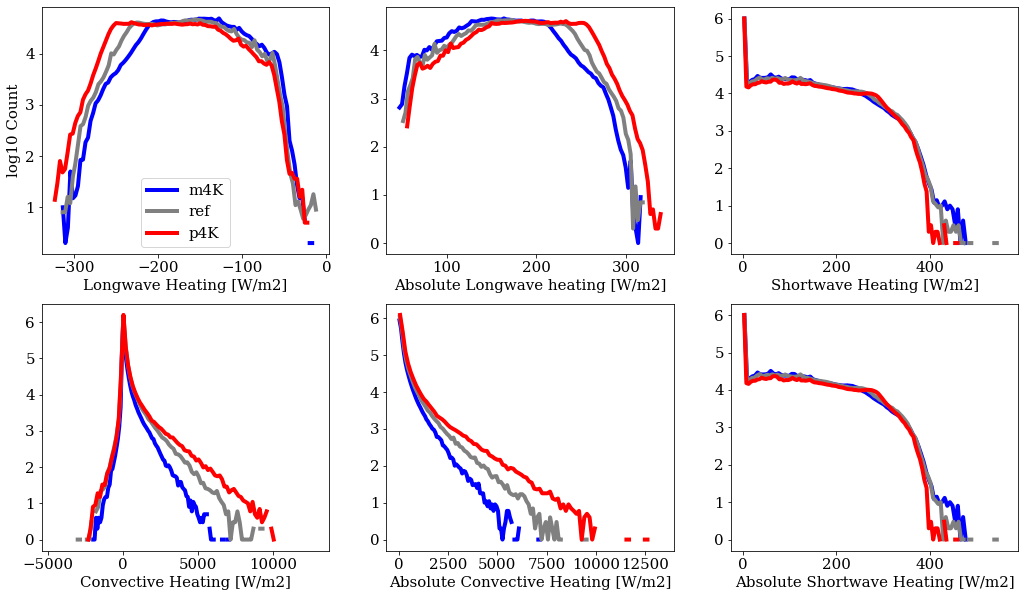

In [48]:
fig,ax = plt.subplots(2,3,figsize=(17.5,10))
for idata,data in enumerate(['m4K','ref','p4K']):
    ax[0,0].plot(edg2bin(LWHIST[data][1]),np.log10(LWHIST[data][0]),color=COLOR[idata],label=data)
ax[0,0].legend()
ax[0,0].set_ylabel('log10 Count')
ax[0,0].set_xlabel('Longwave Heating [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[0,1].plot(edg2bin(ABSLWHIST[data][1]),np.log10(ABSLWHIST[data][0]),color=COLOR[idata])
ax[0,1].set_xlabel('Absolute Longwave heating [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[0,2].plot(edg2bin(SWHIST[data][1]),np.log10(SWHIST[data][0]),color=COLOR[idata])
ax[0,2].set_xlabel('Shortwave Heating [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[1,2].plot(edg2bin(ABSSWHIST[data][1]),np.log10(ABSSWHIST[data][0]),color=COLOR[idata])
ax[1,2].set_xlabel('Absolute Shortwave Heating [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[1,0].plot(edg2bin(CONHIST[data][1]),np.log10(CONHIST[data][0]),color=COLOR[idata])
ax[1,0].set_xlabel('Convective Heating [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[1,1].plot(edg2bin(ABSCONHIST[data][1]),np.log10(ABSCONHIST[data][0]),color=COLOR[idata])
ax[1,1].set_xlabel('Absolute Convective Heating [W/m2]')

In [49]:
HEAT_CRH = {}
ABSHEAT_CRH = {}
MOIST_CRH = {}
ABSMOIST_CRH = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    HEAT_CRH[data] = conditional_avg_and_std(CRHHIST[data][1],CRH[data].flatten(),HEAT[data].flatten())
    MOIST_CRH[data] = conditional_avg_and_std(CRHHIST[data][1],CRH[data].flatten(),MOIST[data].flatten())
    ABSHEAT_CRH[data] = conditional_avg_and_std(CRHHIST[data][1],CRH[data].flatten(),ABSHEAT[data].flatten())
    ABSMOIST_CRH[data] = conditional_avg_and_std(CRHHIST[data][1],CRH[data].flatten(),ABSMOIST[data].flatten())

data= m4K
data= ref / 100  & edge= 1.0885184916203865
data= p4K / 100  & edge= 1.0797505370242735


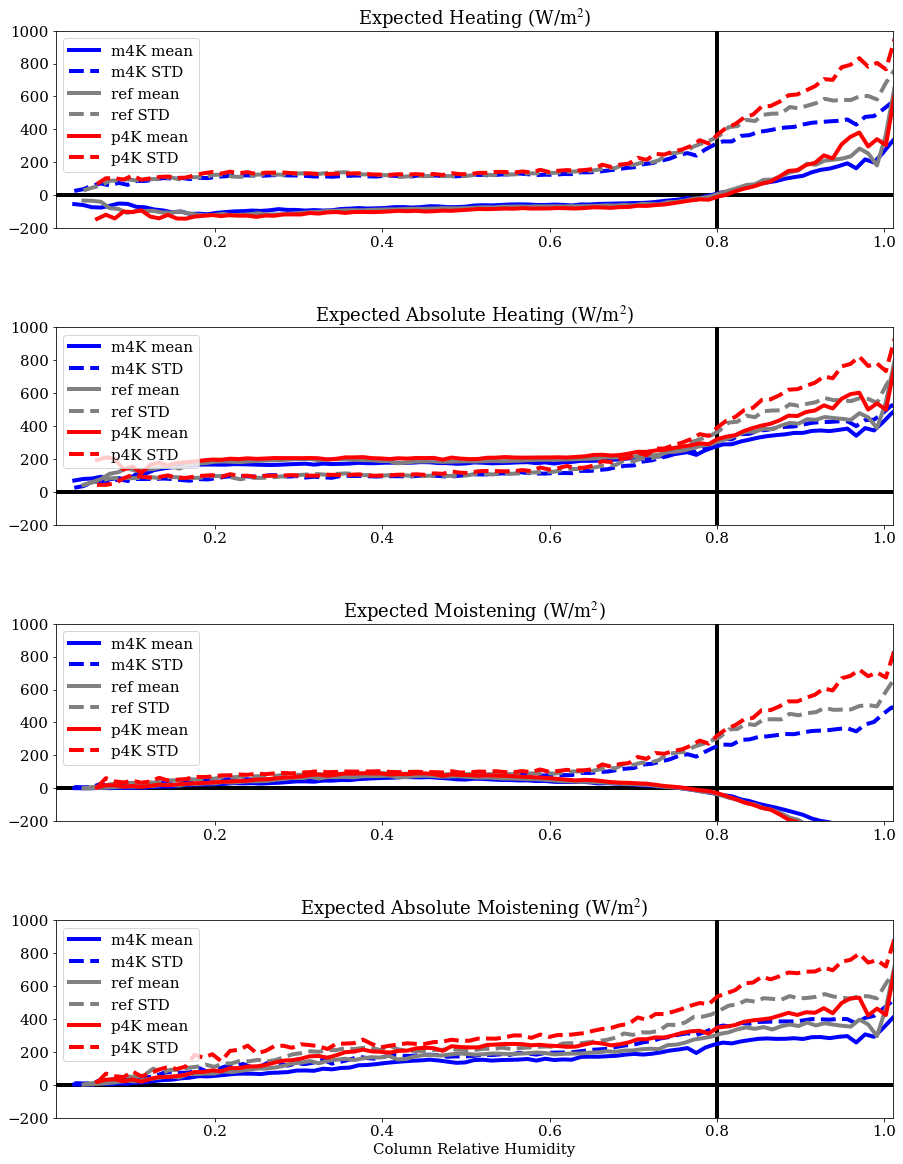

In [50]:
fig,ax = plt.subplots(4,1,figsize=(15,20))
plt.subplots_adjust(hspace=0.5)
for iax in range(4):
    #print('iax=',iax)
    for idata,data in enumerate(['m4K','ref','p4K']):
        #print('data=',data)

        if idata==0: d = datam4K
        elif idata==1: d = dataref
        elif idata==2: d = datap4K
            
        if iax==0: Y = HEAT_CRH[data]; LABEL = 'Expected Heating (W/m$^{2}$)'
        elif iax==1: Y = ABSHEAT_CRH[data]; LABEL = 'Expected Absolute Heating (W/m$^{2}$)'
        elif iax==2: Y = MOIST_CRH[data]; LABEL = 'Expected Moistening (W/m$^{2}$)'
        elif iax==3: Y = ABSMOIST_CRH[data]; LABEL = 'Expected Absolute Moistening (W/m$^{2}$)'
            
        ax[iax].plot(edg2bin(CRHHIST[data][1]),Y[0],color=COLOR[idata],label=data+' mean',linestyle='-')
        ax[iax].plot(edg2bin(CRHHIST[data][1]),Y[1],color=COLOR[idata],label=data+' STD',linestyle='--')
    ax[iax].axvline(x=0.8,color='k',zorder=0)
    ax[iax].axhline(y=0,color='k',zorder=0)
    if iax==3: ax[iax].set_xlabel('Column Relative Humidity')
    ax[iax].set_title(LABEL)
    ax[iax].set_xlim((0.01,1.01))
    ax[iax].set_ylim((-200,1000))
    ax[iax].legend()

In [51]:
LW_CRH = {}
ABSLW_CRH = {}
SW_CRH = {}
ABSSW_CRH = {}
CON_CRH = {}
ABSCON_CRH = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    LW_CRH[data] = conditional_avg_and_std(CRHHIST[data][1],CRH[data].flatten(),LW[data].flatten())
    SW_CRH[data] = conditional_avg_and_std(CRHHIST[data][1],CRH[data].flatten(),SW[data].flatten())
    CON_CRH[data] = conditional_avg_and_std(CRHHIST[data][1],CRH[data].flatten(),CON[data].flatten())
    ABSLW_CRH[data] = conditional_avg_and_std(CRHHIST[data][1],CRH[data].flatten(),ABSLW[data].flatten())
    ABSSW_CRH[data] = conditional_avg_and_std(CRHHIST[data][1],CRH[data].flatten(),ABSSW[data].flatten())
    ABSCON_CRH[data] = conditional_avg_and_std(CRHHIST[data][1],CRH[data].flatten(),ABSCON[data].flatten())

data= m4K
data= ref / 100  & edge= 1.0885184916203865
data= p4K / 100  & edge= 1.0797505370242735


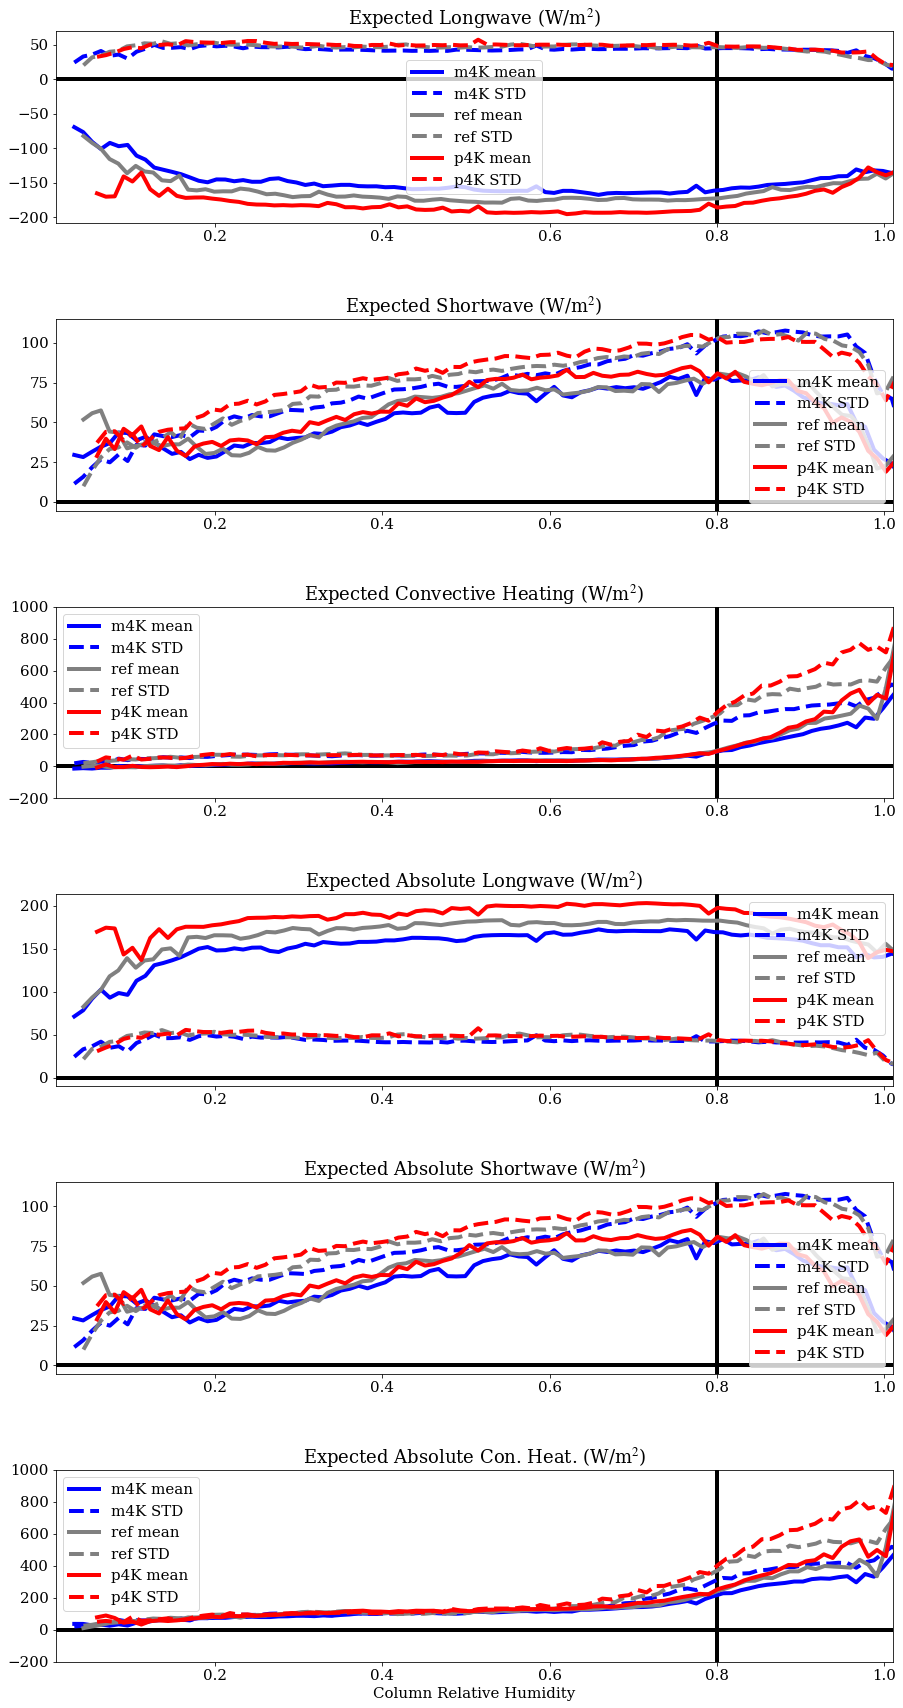

In [54]:
fig,ax = plt.subplots(6,1,figsize=(15,30))
plt.subplots_adjust(hspace=0.5)
for iax in range(6):
    #print('iax=',iax)
    for idata,data in enumerate(['m4K','ref','p4K']):
        #print('data=',data)

        if idata==0: d = datam4K
        elif idata==1: d = dataref
        elif idata==2: d = datap4K
            
        if iax==0: Y = LW_CRH[data]; LABEL = 'Expected Longwave (W/m$^{2}$)'
        elif iax==1: Y = SW_CRH[data]; LABEL = 'Expected Shortwave (W/m$^{2}$)'
        elif iax==2: Y = CON_CRH[data]; LABEL = 'Expected Convective Heating (W/m$^{2}$)'
        elif iax==3: Y = ABSLW_CRH[data]; LABEL = 'Expected Absolute Longwave (W/m$^{2}$)'
        elif iax==4: Y = ABSSW_CRH[data]; LABEL = 'Expected Absolute Shortwave (W/m$^{2}$)'
        elif iax==5: Y = ABSCON_CRH[data]; LABEL = 'Expected Absolute Con. Heat. (W/m$^{2}$)'
            
        ax[iax].plot(edg2bin(CRHHIST[data][1]),Y[0],color=COLOR[idata],label=data+' mean',linestyle='-')
        ax[iax].plot(edg2bin(CRHHIST[data][1]),Y[1],color=COLOR[idata],label=data+' STD',linestyle='--')
    ax[iax].axvline(x=0.8,color='k',zorder=0)
    ax[iax].axhline(y=0,color='k',zorder=0)
    if iax==5: ax[iax].set_xlabel('Column Relative Humidity')
    ax[iax].set_title(LABEL)
    ax[iax].set_xlim((0.01,1.01))
    if iax%3==2: ax[iax].set_ylim((-200,1000))
    ax[iax].legend()

In [58]:
HEATcrhHIST = {}
ABSHEATcrhHIST = {}
MOISTcrhHIST = {}
ABSMOISTcrhHIST = {}

HEATcrhscHIST = {}
ABSHEATcrhscHIST = {}
MOISTcrhscHIST = {}
ABSMOISTcrhscHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    HEATcrhHIST[data] = np.histogram(HEAT[data].flatten()[CRH[data].flatten()>0.8],bins=100)
    ABSHEATcrhHIST[data] = np.histogram(ABSHEAT[data].flatten()[CRH[data].flatten()>0.8],bins=100)
    MOISTcrhHIST[data] = np.histogram(MOIST[data].flatten()[CRH[data].flatten()>0.8],bins=100)
    ABSMOISTcrhHIST[data] = np.histogram(ABSMOIST[data].flatten()[CRH[data].flatten()>0.8],bins=100)
    
    HEATcrhscHIST[data] = np.histogram(HEAT[data].flatten()[CRH[data].flatten()>0.8]/PW[data].flatten()[CRH[data].flatten()>0.8],bins=100)
    ABSHEATcrhscHIST[data] = np.histogram(ABSHEAT[data].flatten()[CRH[data].flatten()>0.8]/PW[data].flatten()[CRH[data].flatten()>0.8],bins=100)
    MOISTcrhscHIST[data] = np.histogram(MOIST[data].flatten()[CRH[data].flatten()>0.8]/PW[data].flatten()[CRH[data].flatten()>0.8],bins=100)
    ABSMOISTcrhscHIST[data] = np.histogram(ABSMOIST[data].flatten()[CRH[data].flatten()>0.8]/PW[data].flatten()[CRH[data].flatten()>0.8],bins=100)

data= m4K
data= ref
data= p4K


/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ip

Text(0.5, 0, 'Abs. heat./PW CRH>0.8 [W/m2]')

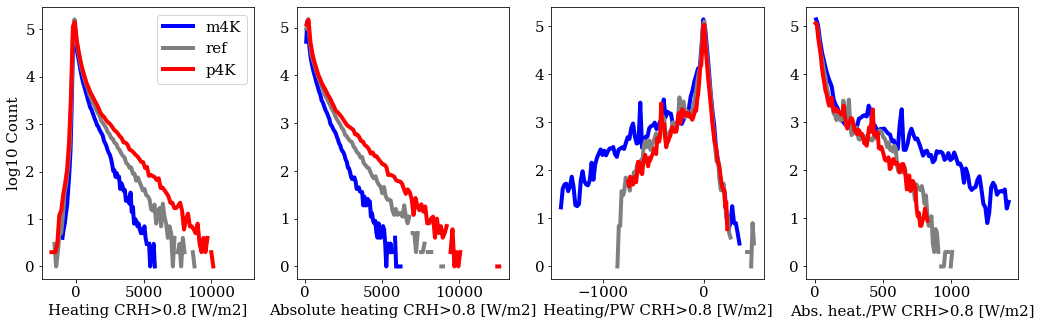

In [59]:
fig,ax = plt.subplots(1,4,figsize=(17.5,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    ax[0].plot(edg2bin(HEATcrhHIST[data][1]),np.log10(HEATcrhHIST[data][0]),color=COLOR[idata],label=data)
ax[0].legend()
ax[0].set_ylabel('log10 Count')
ax[0].set_xlabel('Heating CRH>0.8 [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[1].plot(edg2bin(ABSHEATcrhHIST[data][1]),np.log10(ABSHEATcrhHIST[data][0]),color=COLOR[idata])
ax[1].set_xlabel('Absolute heating CRH>0.8 [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[2].plot(edg2bin(HEATcrhscHIST[data][1]),np.log10(HEATcrhscHIST[data][0]),color=COLOR[idata])
ax[2].set_xlabel('Heating/PW CRH>0.8 [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[3].plot(edg2bin(ABSHEATcrhscHIST[data][1]),np.log10(ABSHEATcrhscHIST[data][0]),color=COLOR[idata])
ax[3].set_xlabel('Abs. heat./PW CRH>0.8 [W/m2]')

/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ip

Text(0.5, 0, 'Abs. Moist./PW CRH>0.8 [W/m2]')

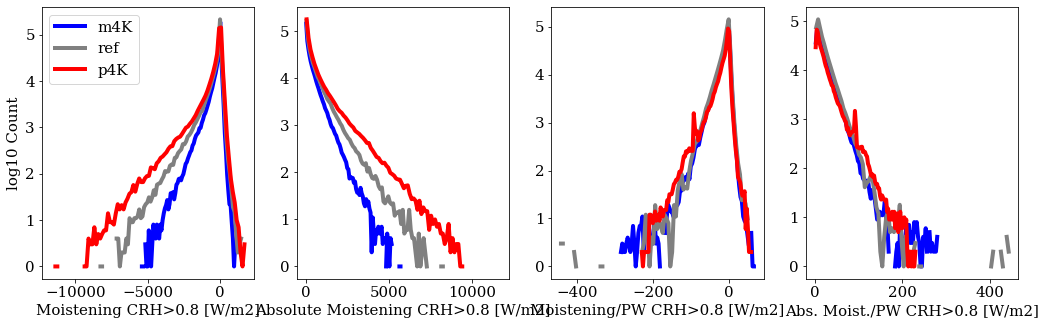

In [61]:
fig,ax = plt.subplots(1,4,figsize=(17.5,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    ax[0].plot(edg2bin(MOISTcrhHIST[data][1]),np.log10(MOISTcrhHIST[data][0]),color=COLOR[idata],label=data)
ax[0].legend()
ax[0].set_ylabel('log10 Count')
ax[0].set_xlabel('Moistening CRH>0.8 [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[1].plot(edg2bin(ABSMOISTcrhHIST[data][1]),np.log10(ABSMOISTcrhHIST[data][0]),color=COLOR[idata])
ax[1].set_xlabel('Absolute Moistening CRH>0.8 [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[2].plot(edg2bin(MOISTcrhscHIST[data][1]),np.log10(MOISTcrhscHIST[data][0]),color=COLOR[idata])
ax[2].set_xlabel('Moistening/PW CRH>0.8 [W/m2]')

for idata,data in enumerate(['m4K','ref','p4K']):
    ax[3].plot(edg2bin(ABSMOISTcrhscHIST[data][1]),np.log10(ABSMOISTcrhscHIST[data][0]),color=COLOR[idata])
ax[3].set_xlabel('Abs. Moist./PW CRH>0.8 [W/m2]')